In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from efficient_apriori import apriori
import networkx as nx
import math


Niniejsza praca przedstawia analizę asocjacji substancji psychoaktywnych wykrywanych w próbkach przesłanych do laboratorium testującego. Celem badania jest identyfikacja wzorców współwystępowania różnych związków chemicznych oraz porównanie deklarowanej przez użytkowników substancji z rzeczywistym składem próbek. Wykorzystując algorytm Apriori do wydobywania reguł asocjacyjnych, analiza ujawnia istotne rozbieżności między oczekiwaniami kupujących a faktyczną zawartością substancji, ze szczególnym uwzględnieniem problematycznej obecności fentanylu i jego pochodnych w próbkach sprzedawanych jako inne opioidy.

Dane pochodzą z : https://www.drugsdata.org/

# Analiza Danych


In [3]:
df=pd.read_csv('drugsdata.csv')
df.head()

,sample_id,sample_name,sold_as,substances,num_substances,amounts,date,location,source
0,20426,NaN,Cannabis,CBD|MDMB-4en-PINACA|THC,3,NaN,"Aug 24, 2024\n(Tested: Aug 15, 2024)","Zurich, \nSwitzerland",SaferParty.ch
1,20425,NaN,3-MMC / 3-Methylmethcathinone,2-Methylmethcathinone,1,NaN,"Aug 24, 2024\n(Tested: Aug 15, 2024)","Zurich, \nSwitzerland",SaferParty.ch
2,20424,NaN,Cocaine,Cocaine|Procaine,2,NaN,"Aug 24, 2024","Zurich, \nSwitzerland",SaferParty.ch
3,20423,NaN,LSD,LSD,1,234.30 ug,"Aug 24, 2024\n(Tested: Aug 17, 2024)","Basel, \nSwitzerland",SaferParty.ch
4,20422,NaN,MDMA / Ecstasy,MDMA,1,239.70 mg,"Aug 24, 2024\n(Tested: Aug 15, 2024)","Lausanne, \nSwitzerland",SaferParty.ch


Dane są zapisane w ramce danych, mamy 20000 rekordów zaaranżowanych w 9 kolumn. Interesują nas kolumna substances, chcemy dowiedzieć się z czym najczęściej mieszane są dane substancje. W tym celu musimy rozkodować kolumne substances. Symbol '|' jest używany w danych do rozdzielnia substancji. Musimy stworzyć "koszyki" dla każdej próbki wysłanej do laboratorium. Ponadto chcemy się dowiedzieć ile jest unikatowych substancji


In [5]:
baskets = df['substances'].str.split('|').tolist()
substances_binary = df['substances'].str.get_dummies(sep='|')

baskets odpwiada 'koszykom' dla każdej próbki. substances_binary zawiera przekodowane na zero jeydnkowe zmienne każdy rodzaj substancji wykrytej w laboratorium. Chcemy dowiedzieć się ile tych unikalnych substancji jest

In [7]:
substances_binary.shape[1]

497

Mamy prawie 500 unikalnych substacnji wykrytych w laboratorium

Zanim przejdzimey do analizy asocjacji zwizualizujmy nasze dane

<Axes: ylabel='None'>

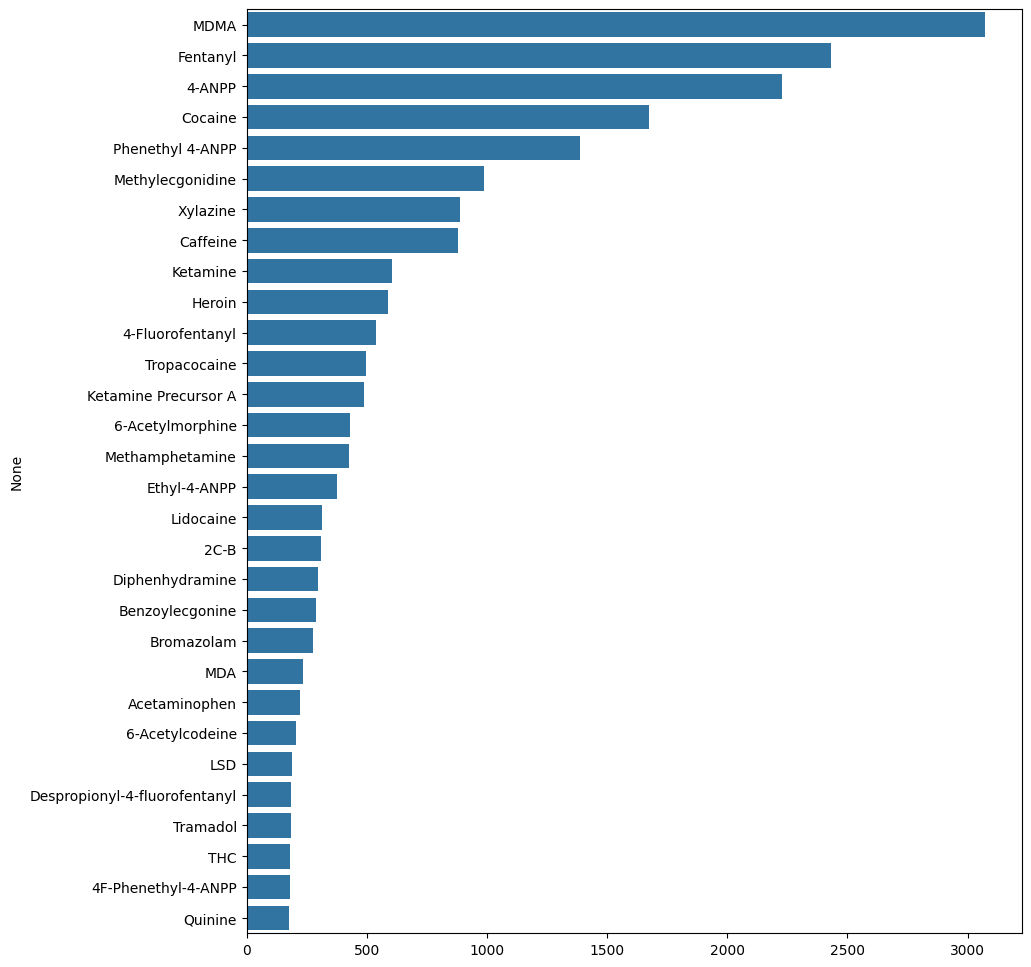

In [10]:
occurrence = substances_binary.sum().sort_values(ascending=False).head(30)

plt.figure(figsize=(10, 12))
sns.barplot(x=occurrence.values, y=occurrence.index)

Widzimy wykres 30 najczęściej występujących substancji. WIdać tu głównie 3 grupy substancji. 
1) Substancje 'imprezowe', stosunkowo lekkie w porównaniu do opioidów jak MDMA i jej pochodne, głównie stymulanty.
2) Mocne stymulanty jak kokaina
3) Opioidy
4) Fentanyl i pochodne, któy technicznie jest opioidem ale wyróżnia się częstością. Ponadtdo warto zwrócić na niego szczególną uwage biorąc pod uwagę wzrost jego popularności w ostatnich latach]
5) Wypełeniacze jak kofeina

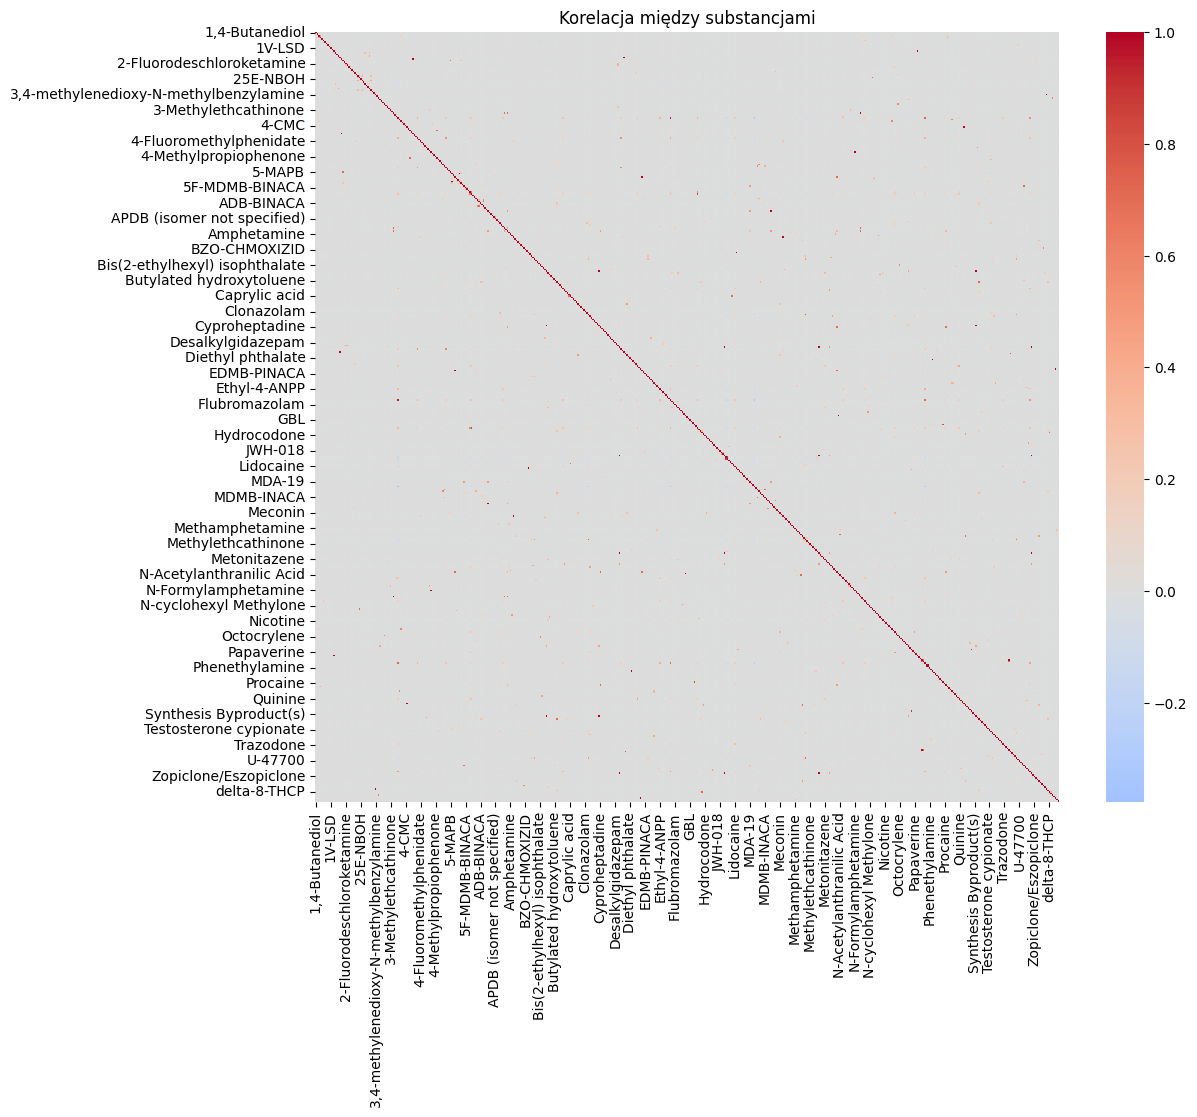

In [12]:
corr = substances_binary.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Korelacja między substancjami")
plt.show()

Wykres korelacji nie mówi nam zbyt wiele. Widać, że korelacja większości substancji z innymi jest zerowa. Jendocześnie widać, że pewne substancje często występują z konkretnymi innymi substancjami.

In [14]:

itemsets, rules = apriori(baskets, min_support=0.01, min_confidence=0.5)

simple_rules = [rule for rule in rules if len(rule.lhs) == 1]
for rule in sorted(simple_rules, key=lambda x: x.lift, reverse=True):
    print(rule)

{THC} -> {CBD} (conf: 0.549, supp: 0.010, lift: 50.408, conv: 2.195)
{CBD} -> {THC} (conf: 0.917, supp: 0.010, lift: 50.408, conv: 11.891)
{4F-Phenethyl-4-ANPP} -> {Despropionyl-4-fluorofentanyl, Fentanyl} (conf: 0.587, supp: 0.011, lift: 33.141, conv: 2.376)
{Despropionyl-4-fluorofentanyl} -> {4F-Phenethyl-4-ANPP} (conf: 0.584, supp: 0.011, lift: 32.614, conv: 2.360)
{4F-Phenethyl-4-ANPP} -> {Despropionyl-4-fluorofentanyl} (conf: 0.603, supp: 0.011, lift: 32.614, conv: 2.474)
{Despropionyl-4-fluorofentanyl} -> {4F-Phenethyl-4-ANPP, Fentanyl} (conf: 0.568, supp: 0.011, lift: 32.432, conv: 2.272)
{Despropionyl-4-fluorofentanyl} -> {4-Fluorofentanyl, 4F-Phenethyl-4-ANPP} (conf: 0.546, supp: 0.010, lift: 32.114, conv: 2.165)
{4F-Phenethyl-4-ANPP} -> {4-Fluorofentanyl, Despropionyl-4-fluorofentanyl} (conf: 0.564, supp: 0.010, lift: 31.878, conv: 2.254)
{6-Acetylcodeine} -> {6-Acetylmorphine, Heroin} (conf: 0.995, supp: 0.021, lift: 23.471, conv: 198.223)
{6-Acetylcodeine} -> {6-Acetylmorph

Wynik jest mało czytelny natomiast można zauważyć pewne wzorce posługując się wiedzą chemiczną. Duża część tych asocjajci to substancje powstające w procesie wytwarzania innej substancji np. Fentanylu dlatego dużo jest reguł z conf=1. Widać, że próbki pochodzą z domowych laboratoriów i są zanieczyszczone odpadami z procesów chemicznych. Postaramy się usunąć chemiczne substancje które są wynikiem procesu wytwarzania niektóych innych substancji a nie domieszkmai.

In [16]:
precursors = [
    '4-ANPP', 'Phenethyl 4-ANPP', 'Ethyl-4-ANPP', '4F-Phenethyl-4-ANPP',
    '6-Acetylcodeine', '6-Acetylmorphine', 
    'Benzoylecgonine', 'Methylecgonidine', 'Tropacocaine',
    'Ketamine Precursor A', 'Despropionyl-4-fluorofentanyl', 
    'N-Boc Norfentanyl', 'Acetylfentanyl','4-Fluorofentanyl'
]
baskets_clean = [[item for item in basket if item not in precursors] for basket in baskets]
baskets_clean = [basket for basket in baskets_clean if len(basket) > 0]

In [17]:
itemsets2, rules2 = apriori(baskets_clean, min_support=0.01, min_confidence=0.3)

simple_rules2 = [rule for rule in rules2 if len(rule.lhs) == 1]
for rule in sorted(simple_rules2, key=lambda x: x.lift, reverse=True):
    print(rule)

{THC} -> {CBD} (conf: 0.549, supp: 0.010, lift: 50.403, conv: 2.195)
{CBD} -> {THC} (conf: 0.917, supp: 0.010, lift: 50.403, conv: 11.891)
{Quinine} -> {Diphenhydramine, Fentanyl} (conf: 0.596, supp: 0.011, lift: 22.136, conv: 2.406)
{Quinine} -> {Diphenhydramine} (conf: 0.646, supp: 0.012, lift: 21.751, conv: 2.741)
{Diphenhydramine} -> {Quinine} (conf: 0.387, supp: 0.012, lift: 21.751, conv: 1.603)
{Diphenhydramine} -> {Fentanyl, Quinine} (conf: 0.357, supp: 0.011, lift: 21.242, conv: 1.529)
{Quinine} -> {Heroin} (conf: 0.562, supp: 0.010, lift: 9.553, conv: 2.148)
{Diphenhydramine} -> {Fentanyl, Heroin} (conf: 0.438, supp: 0.013, lift: 8.401, conv: 1.686)
{Diphenhydramine} -> {Heroin} (conf: 0.465, supp: 0.014, lift: 7.901, conv: 1.758)
{Lidocaine} -> {Caffeine, Fentanyl} (conf: 0.444, supp: 0.014, lift: 7.488, conv: 1.692)
{Xylazine} -> {Caffeine, Fentanyl} (conf: 0.402, supp: 0.036, lift: 6.779, conv: 1.573)
{Heroin} -> {Caffeine, Fentanyl} (conf: 0.401, supp: 0.024, lift: 6.768, 

Mamy wyniki analizy asocjacji. Po pierwsze wyraźnie widać samotny przypadek THC->CBD i CBD->THC. Obie subtsancje pochodzą z konopii z tymże CBD nie wywołuje efektu narkotycznego. CBD prawie zawsze wystęuję z THC, THC z CBD tylko w 50%. W każdym bądź razie jest to silna i osobna para która występuje praktycznie tylko ze sobą. Następnie widzimy zależnosći opioidy/kokaina. 'Królem' opioidów jest fentanyl. Współwystępuje z każdym innym opioidem. Quinine, procaine, diphenhydramine, lidocaine, tramadol, acetaminophen czy heroina wsytępują z fentanylem na poziomie poad 80% każdy. W skrócie prawie wszystkie opioidowe próbki zawierały fentanyl. Mamy również 'klaster' kokainowy. Levamisole/tetramisole to lek przeciwpasożytniczy, benzoic acid to czesto spotykan substancja chemiczna np. jako konserwant. Co zadziwiające brakuje wyraźnych asocjacji dla MDMA któa jest substancją najczęściej występującą w danych, można więc wnioskować, że jest to 'najczystszy' narkotyk bez wyraźnych domieszek. Generlanie można to podsumować tak:
WYSTĘPOWANIE W DANYCH:

Fentanyl: ≈ 24.3%
Cocaine: ≈ 16.8%
Heroin: ≈ 5.9%
THC: ≈ 1.8%

WSPÓŁWYSTĘPOWANIE

Fentanyl → Xylazine: 36.0%

Generlanie można to podsumować tak:

===================================

WYSTĘPOWANIE W DANYCH:

Fentanyl: ≈ 24.3%
Cocaine: ≈ 16.8%
Heroin: ≈ 5.9%
THC: ≈ 1.8%

===================================

WSPÓŁWYSTĘPOWANIE

Fentanyl → Xylazine: 36.0%

Xylazine → Fentanyl: 98.4%

Quinine → Fentanyl: 94.4%

Procaine → Fentanyl: 92.2%

Diphenhydramine → Fentanyl: 90.6%

Tramadol → Fentanyl: 90.2%

Lidocaine → Fentanyl: 84.3%

Caffeine → Fentanyl: 67.3%

Acetaminophen → Fentanyl: 54.3%

=========================================

Tetramisole/Levamisole → Cocaine: 95.1%

Benzoic acid → Cocaine: 86.8%

Cocaine → Fentanyl: 40.8%

========================================

Heroin → Fentanyl: 88.6%

Heroin → Caffeine: 41.8%

Heroin → Xylazine: 39.3%

Heroin → (Caffeine, Fentanyl): 40.1%

Heroin → (Fentanyl, Xylazine): 39.3%

Quinine → Heroin: 56.2%

Diphenhydramine → Heroin: 46.5%

Diphenhydramine → (Fentanyl, Heroin): 43.8%

==========================================

THC → CBD: 54.9%

CBD → THC: 91.7%


### KOD WYKRESU


In [21]:

# 1. Twoje dane wejściowe
raw_rules = """
{THC} -> {CBD} (conf: 0.549, supp: 0.010, lift: 50.403, conv: 2.195)
{CBD} -> {THC} (conf: 0.917, supp: 0.010, lift: 50.403, conv: 11.891)
{Quinine} -> {Diphenhydramine, Fentanyl} (conf: 0.596, supp: 0.011, lift: 22.136, conv: 2.406)
{Quinine} -> {Diphenhydramine} (conf: 0.646, supp: 0.012, lift: 21.751, conv: 2.741)
{Diphenhydramine} -> {Quinine} (conf: 0.387, supp: 0.012, lift: 21.751, conv: 1.603)
{Diphenhydramine} -> {Fentanyl, Quinine} (conf: 0.357, supp: 0.011, lift: 21.242, conv: 1.529)
{Quinine} -> {Heroin} (conf: 0.562, supp: 0.010, lift: 9.553, conv: 2.148)
{Diphenhydramine} -> {Fentanyl, Heroin} (conf: 0.438, supp: 0.013, lift: 8.401, conv: 1.686)
{Diphenhydramine} -> {Heroin} (conf: 0.465, supp: 0.014, lift: 7.901, conv: 1.758)
{Lidocaine} -> {Caffeine, Fentanyl} (conf: 0.444, supp: 0.014, lift: 7.488, conv: 1.692)
{Xylazine} -> {Caffeine, Fentanyl} (conf: 0.402, supp: 0.036, lift: 6.779, conv: 1.573)
{Heroin} -> {Caffeine, Fentanyl} (conf: 0.401, supp: 0.024, lift: 6.768, conv: 1.571)
{Tetramisole / Levamisole} -> {Cocaine} (conf: 0.951, supp: 0.012, lift: 5.676, conv: 16.927)
{Lidocaine} -> {Caffeine} (conf: 0.470, supp: 0.015, lift: 5.330, conv: 1.719)
{Benzoic acid} -> {Cocaine} (conf: 0.868, supp: 0.015, lift: 5.180, conv: 6.298)
{Heroin} -> {Caffeine} (conf: 0.418, supp: 0.025, lift: 4.748, conv: 1.568)
{Caffeine} -> {Fentanyl, Xylazine} (conf: 0.405, supp: 0.036, lift: 4.636, conv: 1.534)
{Xylazine} -> {Caffeine} (conf: 0.403, supp: 0.036, lift: 4.576, conv: 1.528)
{Caffeine} -> {Xylazine} (conf: 0.406, supp: 0.036, lift: 4.576, conv: 1.535)
{Lidocaine} -> {Xylazine} (conf: 0.403, supp: 0.013, lift: 4.533, conv: 1.525)
{Lidocaine} -> {Fentanyl, Xylazine} (conf: 0.396, supp: 0.012, lift: 4.532, conv: 1.511)
{Heroin} -> {Fentanyl, Xylazine} (conf: 0.393, supp: 0.023, lift: 4.494, conv: 1.503)
{Heroin} -> {Xylazine} (conf: 0.393, supp: 0.023, lift: 4.424, conv: 1.501)
{Xylazine} -> {Fentanyl} (conf: 0.984, supp: 0.087, lift: 4.048, conv: 48.008)
{Fentanyl} -> {Xylazine} (conf: 0.360, supp: 0.087, lift: 4.048, conv: 1.423)
{Quinine} -> {Fentanyl} (conf: 0.944, supp: 0.017, lift: 3.882, conv: 13.472)
{Procaine} -> {Fentanyl} (conf: 0.922, supp: 0.013, lift: 3.792, conv: 9.702)
{Diphenhydramine} -> {Fentanyl} (conf: 0.906, supp: 0.027, lift: 3.725, conv: 8.028)
{Tramadol} -> {Fentanyl} (conf: 0.902, supp: 0.017, lift: 3.711, conv: 7.737)
{Heroin} -> {Fentanyl} (conf: 0.886, supp: 0.052, lift: 3.644, conv: 6.642)
{Lidocaine} -> {Fentanyl} (conf: 0.843, supp: 0.026, lift: 3.469, conv: 4.835)
{Caffeine} -> {Fentanyl} (conf: 0.673, supp: 0.059, lift: 2.769, conv: 2.315)
{Acetaminophen} -> {Fentanyl} (conf: 0.543, supp: 0.012, lift: 2.233, conv: 1.656)
{Cocaine} -> {Fentanyl} (conf: 0.408, supp: 0.068, lift: 1.677, conv: 1.278)
"""

# 2. Parsowanie danych
parsed = []
for line in raw_rules.strip().split('\n'):
    p = line.split(' -> ')
    lhs, rhs_full = p[0].strip('{} '), p[1].split(' (')[0].strip('{} ')
    conf = float(p[1].split('conf: ')[1].split(',')[0])
    parsed.append((lhs, rhs_full, conf))


### WYKRESY

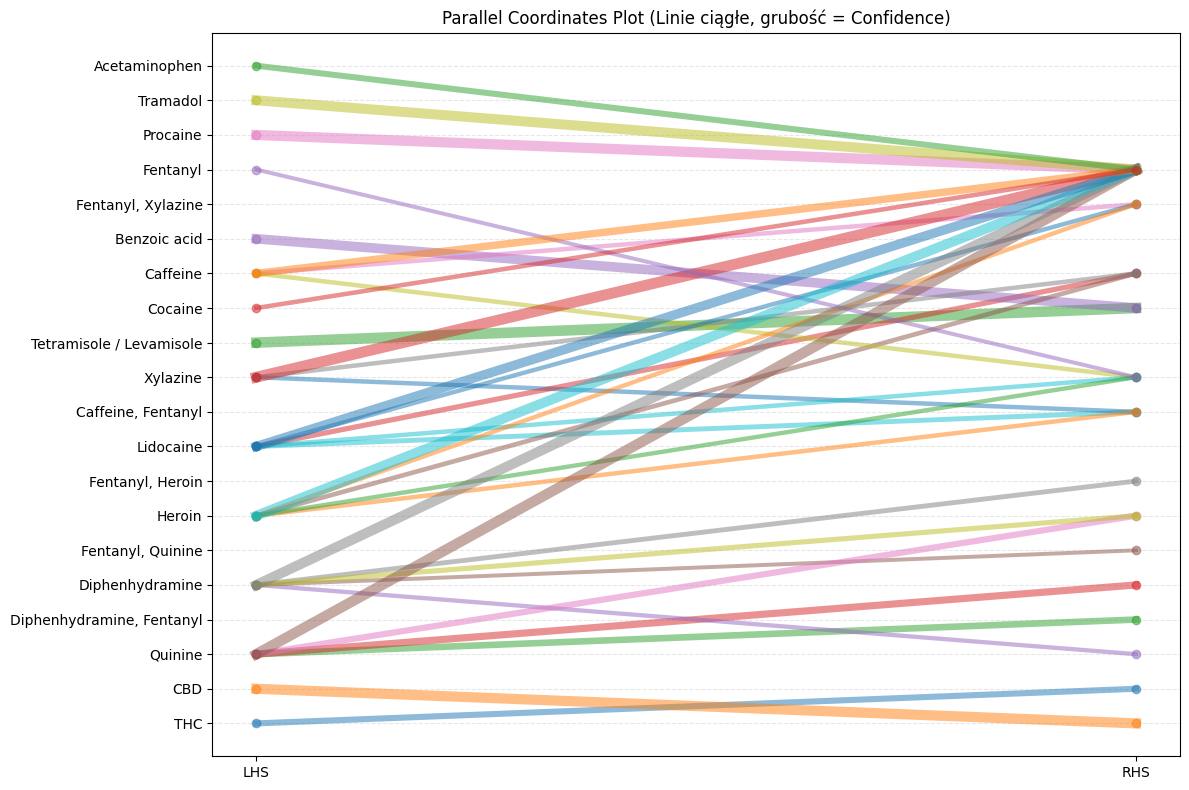

In [23]:
plt.figure(figsize=(12, 8))
for lhs, rhs, conf in parsed:
    plt.plot(['LHS', 'RHS'], [lhs, rhs], marker='o', 
             linestyle='-', linewidth=conf*8, alpha=0.5)

plt.title("Parallel Coordinates Plot (Linie ciągłe, grubość = Confidence)")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

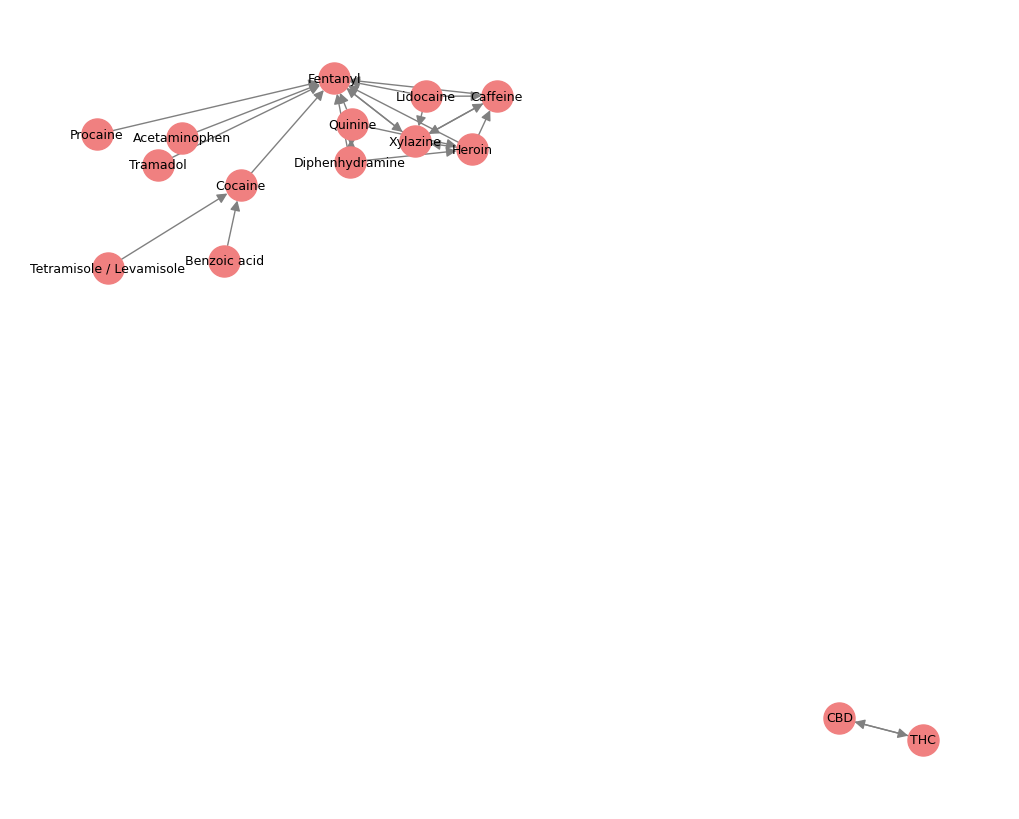

In [24]:
G = nx.DiGraph()
for r in sorted(simple_rules2, key=lambda x: x.lift, reverse=True)[:1000]:
    G.add_edge(list(r.lhs)[0], list(r.rhs)[0])

# 2. Rysowanie
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightcoral', node_size=500, 
        font_size=9, arrowsize=15, edge_color='gray')
plt.show()

Przejdźmy teraz do drugiego intereusjącego nas pytania: Co kupujący myśli, że kupuje vs co dostaje. W tym celu wyciągniemy z kolumny 'sold_as' nazwy  pod którymi substancje były sprzedawane. Z rajci na to, że nazw tych jest bardzo dużo (zależą od opisu przesłąnej do laboratorium próbki) i często różne opisy sugerują tą samą substancję zagregujemy je do do typów jak MDMA,KOKAINA itp.

## Obróbka danych

In [27]:
sold_as = df['sold_as'].str.get_dummies()

In [28]:
sold_as

,#4 Heroin,''4mg bromaz dose xanax'',''Excellent Molly'' MDMA,'Champagne' MDMA,'Dog Food' Heroin,'Oxy','Pure Cocaine',(Raw) Opium,"(not sold, gifted) Cannabis","1,3-Dimethylamylamine",...,Zanax,Zolpidem,Zolpidem IP,a-PCYP,a-PVP,alpha-PHP,bk-MDMA / Methylone,bk-MDMA or bk-MDEA,d-Methamphetamine,natural Cannabis Oil
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
print(sold_as.columns.tolist())

['#4 Heroin', "''4mg bromaz dose xanax''", "''Excellent Molly'' MDMA", "'Champagne' MDMA", "'Dog Food' Heroin", "'Oxy'", "'Pure Cocaine'", '(Raw) Opium', '(not sold, gifted) Cannabis', '1,3-Dimethylamylamine', '10mg Hydrocodone/325mg Acetaminophen', '10mg Oxycodone/325mg Acetaminophen', '15 mg Oxycodone', '1D-LSD', '1P-LSD', '1V-LSD', '1cp-LSD', '2-A1MP', '2-Bromomescaline', '2-CB', '2-FDCK', '2-FMA', '2-Fluorodeschloroketamine', '2-Oxo-PCE', '20mg Oxycodone', '20mg Oxycodone ER', '25E-NBOH', '25I-NBOMe', '25x-NBOMe', '2C, Tusi', '2C-B', '2C-B + MDMA', '2C-B / Tucibi', '2C-B HBr', '2C-B HCl', '2C-D', '2C-E', '2C-EF', '2C-I', '2C-I HCl', '2C-P', '2C-T', '2C-T-2', '2CB', '2F', '2F-DCK', '2mg Alprazolam', '2mg Xanax', '2mg Xanax Bar', '2mg Xanax bars', '3-CMC', '3-Cl-PCP', '3-FL-PCP', '3-Fluoro-2-oxo-PCE (Fluorexetamine)', '3-HO-PCP', '3-MMC', '3-MMC / 3-Methylmethcathinone', '3-Methylmethcathinone', '3-Methylmethcathinone (3-MMC)', '3-hydroxy-PCP', '3.5mg Alprazolam', '30mg IR Adderall',

In [30]:
def map_to_group_clean(label):
    l = str(label).lower().strip()

    if any(x in l for x in [
        'fentanyl','fent','fetty','feentanyl','fentanly',
        'm30','blues','china white','down',
        'carfentanil','4-fluorofentanyl',
        'isotonitazene','metonitazene','protonitazene','nitazene',
        'etodesnitazene','etomethazene','etonitazepipne','n-desethyl',
        'piperidylthiambutene'
    ]):
        return 'MARKET_FENTANYL'

    if any(x in l for x in [
        'heroin','herion','brown','afghan','afghani','tar','black tar',
        'dog food','#4','h ','real heroin',
        '(raw) opium','opium'
    ]):
        return 'MARKET_HEROIN'

    if any(x in l for x in [
        'oxy','oxycodone','oxycontin','oxynorm','oc',
        'perc','percocet','roxicodone',
        'hydrocodone','vicodin','norco',
        'dilaudid','hydromorphone',
        'morphine','morfina',
        'codeine',
        'tramadol','tapentadol',
        'o-dsmt','odsmt'
    ]):
        return 'MARKET_PHARMA_OPIOIDS'

    if any(x in l for x in [
        'xanax','alprazolam','zanax','benzo',
        'bromazolam','clonazepam','klonopin','rivotril',
        'diazepam','valium',
        'lorazepam','ativan',
        'etizolam','clonazolam',
        'flualprazolam','flubromazepam','flubromazolam',
        'pyrazolam',
        'zolpidem','ambien','belbien',
        'lunesta','eszopiclone','z-drug'
    ]):
        return 'MARKET_BENZOS'

    if any(x in l for x in [
        'mdma','molly','ecstasy','xtc','mda','sassafras','sass',
        'bk-mdma','methylone',
        '5-apb','6-apb','5-mapb',
        'excellent molly','purple amethyst','champagne','dutch mdma',
        '99% pure mdma','99% pure'
    ]):
        return 'MARKET_MDMA'

    if any(x in l for x in [
        'cocaine','cocoaine','coca','coke',
        'crack','blow','hard','rock','freebase',
        'uncut cocaine','cocaine shakes','ether washed',
        'pure cocaine','peruvian','bolivian','columbian','cali cocaine'
    ]):
        return 'MARKET_COCAINE'

    if any(x in l for x in [
        'tusi','tucibi','tusibi','tucibi/pink cocaine',
        'pink cocaine','pink tuci','pink tusi','yellow tusi',
        '2c-b','2cb','2c, tusi','2c-b / tucibi','2c-b / tucibi',
        '2c-b hbr','2c-b hcl','2c-b + mdma'
    ]):
        return 'MARKET_TUSI_2CB'


    if any(x in l for x in [
        'ritalin','methylphenidate','metylofenidat',
        '4f-mph','4f-mph','4f','4-metmp','4-metmp','4-mph','4f-mph',
        'adderall','adderal','vyvanse',
        'dexamphetamine','dexedrine','lisdexamphetamine',
        'focalin'
    ]):
        return 'MARKET_ADHD'

    if any(x in l for x in [
        'methamphetamine','crystal meth','crystal meth','ice','meth','desoxyn'
    ]):
        return 'MARKET_METH'


    if any(x in l for x in [
        'amphetamine','amphetamines','speed',
        'amphetamine sulfate','amphetamine paste',
        'base or amphetamine','captagon','fenethylline'
    ]):
        return 'MARKET_AMPHETAMINE'


    if any(x in l for x in [
        '3-mmc','4-mmc','mephedrone','methylmethcathinone',
        '3-cmc','4-cmc','chloromethcathinone',
        'cathinone',
        'a-php','alpha-php','a-pihp','a-piHP','alpha-pihp',
        'a-pvp','a-pcyp','a-pcyp','pvp','pentedrone','hexedrone',
        'nep','n-ethylpentedrone',
        '4-fa','2-fma','4-methylaminorex'
    ]):
        return 'MARKET_RC_STIMULANTS'


    if any(x in l for x in [
        'lsd','acid','lsd-25',
        '1p-lsd','1v-lsd','1d-lsd','1cp-lsd','1cp',
        'al-lad','ald-52','eth-lad','lssa','lsa'
    ]):
        return 'MARKET_LSD'

    if any(x in l for x in [
        'mushrooms','mushroom','shroom',
        'psilocybin','psilocin','psilocybe',
        'shroom pill','mushroom gummies','mushroom in capsule',
        'psychedelic mushroom','magic mushroom','magic mashrooms'
    ]):
        return 'MARKET_MUSHROOMS'

    if any(x in l for x in [
        'dmt','n,n-dmt','5-meo-dmt','5-meo',
        '4-aco-dmt','4-acetoxy-dmt','4-aco',
        '4-ho-met','4-ho-mipt','4-ho-ept',
        'dpt','det','dipt','amt','5-apb','5-mapb','5-meo-mipt','5-meo-dalt','5-meo-dipt'
    ]):
        return 'MARKET_TRYPTAMINES'


    if any(x in l for x in [
        '25i-nbome','25x-nbome','nbome',
        '25e-nboh','nboh',
        '2c-i','2c-e','2c-d','2c-p','2c-t','2c-t-2','2c-ef',
        'doc','dom','tma-2',
        'mescaline','2-bromomescaline','methallylescaline'
    ]):
        return 'MARKET_PSYCH_PHENETHYLAMINES'


    if any(x in l for x in [
        'ketamine','ket','esketamine','k ',
        '2-fdck','2f-dck','dck','dmxe','mxe','fxe',
        'o-pce','2-oxo-pce','2-oxo',
        'pcp','angel dust','3-ho-pcp','3-cl-pcp','3-fl-pcp','3-hydroxy-pcp',
        '3-fluoro-2-oxo-pce','fluorexetamine','2-fluorodeschloroketamine'
    ]):
        return 'MARKET_DISSOCIATIVES'


    if any(x in l for x in [
        'cannabis','weed','marijuana',
        'thc','hash','haschisch','hashisch',
        'cbd','hhc','delta-8','delta-9','d-8','d-8mh','d-8r',
        'spice','k2','jwh','jwh-'
    ]):
        return 'MARKET_CANNABIS'


    if any(x in l for x in [
        'ghb','gbl','1,4-bdo','phenibut','gabapentin','pregabalin','baclofen','carisoprodol','soma'
    ]):
        return 'MARKET_DEPRESSANTS_OTHER'

    return 'MARKET_OTHER'

column_mapping = {col: map_to_group_clean(col) for col in sold_as.columns}
sold_as_grouped = sold_as.groupby(column_mapping, axis=1).sum()
sold_as_grouped = (sold_as_grouped > 0).astype(int)
big_df = pd.concat([
    sold_as_grouped.reset_index(drop=True),
    substances_binary.reset_index(drop=True)
], axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_14296\2473927532.py:168: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sold_as_grouped = sold_as.groupby(column_mapping, axis=1).sum()


In [31]:
precursors = [
    '4-ANPP', 'Phenethyl 4-ANPP', 'Ethyl-4-ANPP', '4F-Phenethyl-4-ANPP',
    '6-Acetylcodeine', '6-Acetylmorphine', 
    'Benzoylecgonine', 'Methylecgonidine', 'Tropacocaine',
    'Ketamine Precursor A', 'Despropionyl-4-fluorofentanyl', 
    'N-Boc Norfentanyl', 'Acetylfentanyl','4-Fluorofentanyl'
]


cols_to_drop = [c for c in precursors if c in big_df.columns]
big_df = big_df.drop(columns=cols_to_drop)



In [32]:
transactions = []
for _, row in big_df.iterrows():

    transaction = row.index[row == 1].tolist()
    transactions.append(transaction)

itemsets3, rules3 = apriori(transactions, min_support=0.01, min_confidence=0.1)


## Wyniki

In [34]:

simple_rules3 = [rule for rule in rules3 if len(rule.lhs) == 1 and str(rule.lhs[0]).startswith('MARKET_')]

for rule in sorted(simple_rules3, key=lambda x: x.lift, reverse=True):
    print(rule)

{MARKET_LSD} -> {LSD} (conf: 0.817, supp: 0.018, lift: 42.793, conv: 5.370)
{MARKET_CANNABIS} -> {THC} (conf: 0.599, supp: 0.010, lift: 32.901, conv: 2.447)
{MARKET_TUSI_2CB} -> {2C-B} (conf: 0.755, supp: 0.026, lift: 24.437, conv: 3.957)
{MARKET_BENZOS} -> {Alprazolam} (conf: 0.207, supp: 0.012, lift: 15.249, conv: 1.244)
{MARKET_ADHD} -> {Methamphetamine} (conf: 0.634, supp: 0.010, lift: 14.886, conv: 2.617)
{MARKET_DISSOCIATIVES} -> {Ketamine} (conf: 0.872, supp: 0.043, lift: 14.369, conv: 7.350)
{MARKET_BENZOS} -> {Bromazolam} (conf: 0.378, supp: 0.021, lift: 13.641, conv: 1.563)
{MARKET_HEROIN} -> {Caffeine, Heroin} (conf: 0.196, supp: 0.011, lift: 7.966, conv: 1.213)
{MARKET_HEROIN} -> {Heroin} (conf: 0.421, supp: 0.023, lift: 7.164, conv: 1.626)
{MARKET_HEROIN} -> {Caffeine, Fentanyl, Xylazine} (conf: 0.240, supp: 0.013, lift: 6.721, conv: 1.269)
{MARKET_HEROIN} -> {Caffeine, Xylazine} (conf: 0.240, supp: 0.013, lift: 6.702, conv: 1.269)
{MARKET_HEROIN} -> {Fentanyl, Heroin} (co

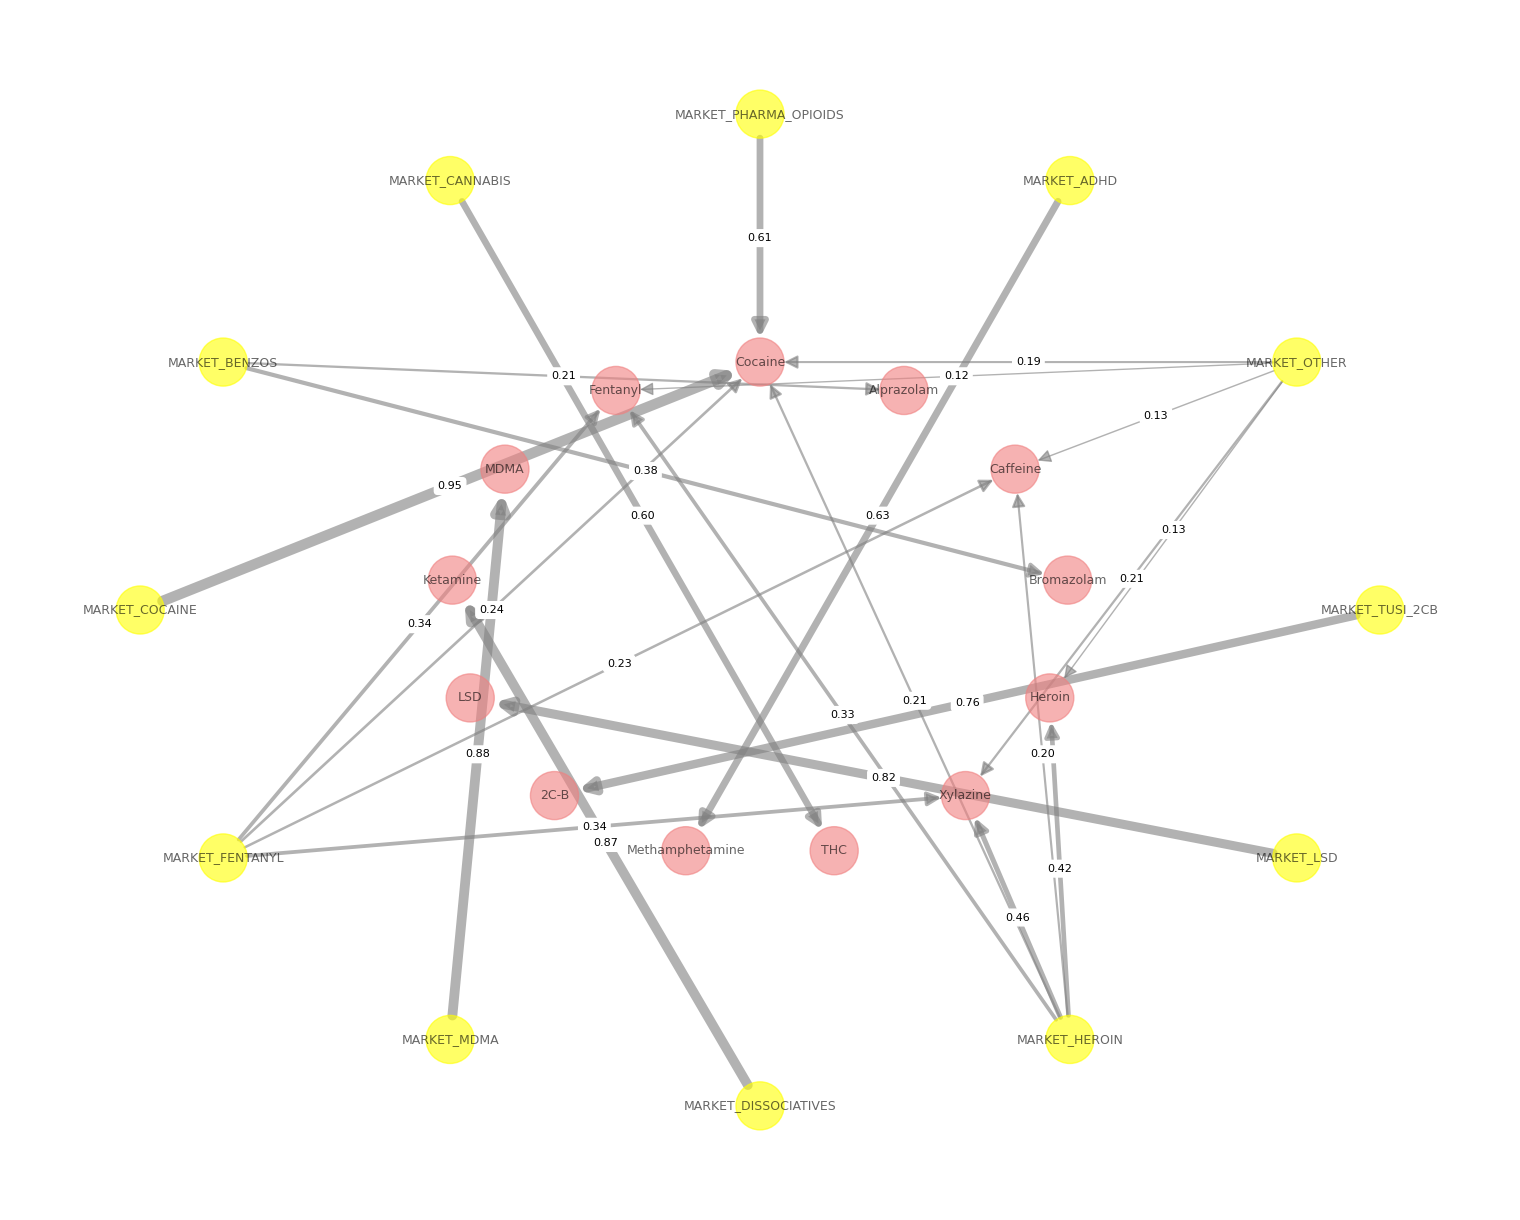

In [35]:
D = nx.DiGraph()

for r in sorted(simple_rules3, key=lambda x: x.confidence, reverse=True)[:100000]:
    lhs = list(r.lhs)[0]
    rhs = list(r.rhs)[0]
    D.add_edge(lhs, rhs, w=r.confidence)

markets = [n for n in D.nodes() if str(n).startswith('MARKET_')]
substances = [n for n in D.nodes() if n not in markets]

pos = nx.shell_layout(D, nlist=[substances, markets])

plt.figure(figsize=(15, 12))
colors = ['yellow' if n in markets else 'lightcoral' for n in D.nodes()]
weights = [D[u][v]['w'] * 8 for u, v in D.edges()]

nx.draw(
    D, pos, with_labels=True,
    node_color=colors,
    node_size=1200,
    font_size=9,
    arrowsize=20,
    width=weights,
    edge_color='grey',
    alpha=0.6
)

# --- DODANE: etykiety na strzałkach (confidence) ---
edge_labels = {(u, v): f"{D[u][v]['w']:.2f}" for u, v in D.edges()}
nx.draw_networkx_edge_labels(
    D, pos,
    edge_labels=edge_labels,
    font_size=8,
    rotate=False
)

plt.show()

W analizie reguł asocjacyjnych potraktowano etykiety MARKET_* jako deklarowany typ zakupu (to, czego użytkownik spodziewał się otrzymać), natomiast zestaw wykrytych związków chemicznych jako rzeczywisty skład próbki. Dla części kategorii zgodność deklaracji ze składem jest wysoka: w szczególności dotyczy to kokainy (MARKET_COCAINE → Cocaine, conf≈0.95), MDMA (MARKET_MDMA → MDMA, conf≈0.88), dysocjantów (MARKET_DISSOCIATIVES → Ketamine, conf≈0.87) oraz LSD (MARKET_LSD → LSD, conf≈0.82). Oznacza to, że w tych 'segmentach rynku' najczęściej rzeczywiście wykrywana jest substancja, której kupujący się spodziewa.

Największe rozbieżności występują w obszarze opioidów. Dla próbek oznaczonych jako MARKET_HEROIN sama heroina pojawia się relatywnie rzadziej (conf≈0.42), natomiast bardzo często współwystępują tam fentanyl (conf≈0.85) oraz ksylazyna (conf≈0.46), a także ich kombinacje, niekiedy z dodatkiem kofeiny. Wynik ten sugeruje, że „rynek heroiny” w badanym zbiorze w dużej mierze odpowiada mieszaninom o zmiennym składzie, a nie jednorodnym próbkom heroiny. Z kolei kategoria MARKET_FENTANYL jest bardziej spójna (obecność fentanylu conf≈0.92), jednak również tutaj widoczne są domieszki, zwłaszcza ksylazyny (około 1/3 przypadków) oraz sporadycznie innych związków.

Istotny i nieintuicyjny rezultat dotyczy kategorii MARKET_PHARMA_OPIOIDS (apotyczne opioidy): w tej grupie najczęściej wykrywana jest kokaina (MARKET_PHARMA_OPIOIDS → Cocaine, conf≈0.61). Oznacza to, że w badanych danych próbki klasyfikowane jako „pharma opioids” częściej przypominają pod względem składu rynek kokainowy niż typowe próbki z dominującymi opioidami